In [2]:
import os 
import numpy as np
import pandas as pd
from pyts.image import RecurrencePlot
import scipy.signal as scisig
from sklearn.utils.validation import check_array
from PIL.Image import Resampling
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
import torchvision
# from torchvision import transform


plt.style.use('ggplot')

In [3]:
def butter_filter(data, cutoff, order, btype, fs= 20):

    nyq = 0.5 * fs
    normal_cutoff = np.array(cutoff) / nyq
    b, a = scisig.butter(order, normal_cutoff.tolist(), btype=btype, analog=False)
    y = scisig.lfilter(b, a, data)
    return y


def recover_data_from_df(csv_path= "../data/processed/final/train_val_test", filter= False):

    data_splits = {t.split('.')[0] : t for t in os.listdir(csv_path)}
    final_data = {key : [] for key in data_splits}
    final_targets = {key : [] for key in data_splits}
    final_names = {key : [] for key in data_splits}


    for dt, dpath in data_splits.items(): 
        final_path = os.path.join(csv_path, dpath)

        for sample, df in pd.read_csv(final_path).groupby('sample'):
            
            label = df['label'].iloc[0]
            workout = df['Workout'].iloc[0]
            df.drop(columns=['sample', 'label', 'Workout'], inplace=True)

            apn_obj = df.T.values

            if filter:
                apn_obj = butter_filter(df.T.values, (.1, 5), 3, 'bandpass')

            final_data[dt].append(apn_obj)
            final_targets[dt].append(label)
            final_names[dt].append(workout)


        final_targets[dt] = np.array(final_targets[dt])

    return final_data, final_targets, final_names

ft, fy, fn = recover_data_from_df(filter=False)

In [4]:
shapes = np.array([k.shape[-1] for k in ft['validation_data']])

shapes.min(), shapes.mean(), shapes.max()

len(shapes[shapes < 600]) , len(shapes), (40/383)

(10, 107, 0.10443864229765012)

In [5]:
def norm_2(arr):
    return np.sqrt(np.sum(arr**2, axis=0)).reshape(1, -1)

def norm_3(arr):
    return np.cbrt(np.sum(arr**3, axis=0)).reshape(1, -1)

def min_max_norm(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

def transform_one_rp(data):
    rp = RecurrencePlot(threshold='distance', percentage=10)

    ### extracting ACC and GYR resultant channels
    acc = min_max_norm(norm_3(data[0:3]))
    gyr = min_max_norm(norm_3(data[3:6]))
    cap = min_max_norm(data[-1].reshape(1, -1))


    rp_acc = rp.transform(acc)
    rp_gyr = rp.transform(gyr)
    rp_cap = rp.transform(cap)

    rp = np.concat([rp_acc, rp_cap,])



$$P[i,j] = \left\lfloor 255  \times \frac{d(x[i], x[j]) - d_{min}}{d_{max} - d_{min}}  \right\rfloor$$

equacao do paper nao funciona, so gera imagens pretas

In [ ]:
class RecurrenceTransformer():

    def __init__(self, output_size):
        self.resizer = torchvision.transforms.Resize(size=(output_size,output_size))

    def get_distance_matrix(self, X, e = 0.1):

        X = check_array(X)
        d = np.abs(X[:, :, None] - X[:, None, :])
        for i, ch in enumerate(d):
            MinMaxScaler((0,1), copy=False).fit_transform(ch)

        return d

    def resize_img(self, sample):
        y_size, x_size = sample.shape[1], sample.shape[2]
        
        print(sample.shape)

        torch_img = torch.from_numpy(sample.reshape(-1, y_size, x_size))
        img = self.resizer.forward(torch_img)
        return img       


In [ ]:
rt = RecurrenceTransformer(output_size=224)

dist = rt.get_distance_matrix(ft['train_data'][0])


In [73]:
class Ts2RecurrencePlot(Dataset):

    def __init__(self, x, y, output=224):

        self.x = x
        self.y = y
        self.rt = torchvision.transforms.Resize(size=(output,output))

    def __get_distance_matrix(self, X, e = 0.1):

        X = check_array(X)
        d = np.abs(X[:, :, None] - X[:, None, :])
        for i, ch in enumerate(d):
            MinMaxScaler((0,1), copy=False).fit_transform(ch)

        return d

    def __resize_img(self, sample):
        
        y_size, x_size = sample.shape[1], sample.shape[-1]


        torch_img = torch.from_numpy(sample.reshape(-1, y_size, x_size))
        img = self.rt.forward(torch_img)
        return img       


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        t = self.x[idx]
        dist_matrix = self.__get_distance_matrix(t)
        acc_rp, gyr_rp, cap = dist_matrix[:3], dist_matrix[3:6], dist_matrix[-1]

        acc_rp = self.__resize_img(acc_rp)
        gyr_rp = self.__resize_img(gyr_rp)
        cap = self.__resize_img(cap)

        return (acc_rp, gyr_rp, cap), self.y[idx]
    

ts_data = Ts2RecurrencePlot(ft['train_data'], fy['train_data'])


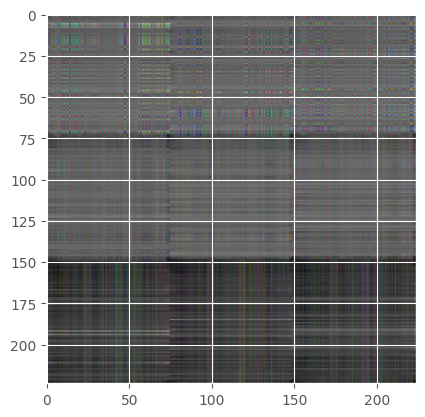

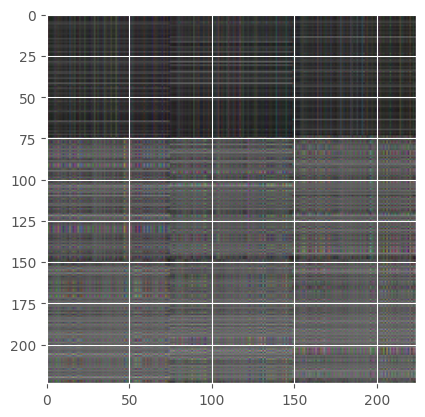

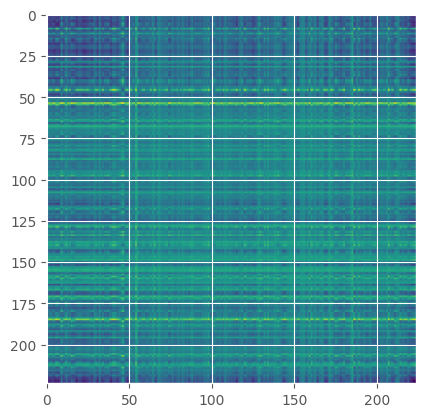

In [77]:
(acc_rp, gyr_rp, cap), y = ts_data[0]

plt.imshow(acc_rp.reshape(224, 224, -1))
plt.show()
plt.imshow(gyr_rp.reshape(224, 224, -1))
plt.show()


plt.imshow(cap.reshape(224, 224, -1))
